In [1]:
import sys
sys.path.append('/lmh_data/work/sclab/train/')

import anndata
import numpy as np
import pandas as pd
import h5py
from scipy import stats

from util import array2mat, mat2array

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# random.seed(0)
np.random.seed(0)

In [3]:
cerebellum_astro = h5py.File('/lmh_data/data/sclab/Astro_bulk_hic/ENCFF027IEO.h5', 'r')
spinal_cord_astro = h5py.File('/lmh_data/data/sclab/Astro_bulk_hic/ENCFF715HDW.h5', 'r')

In [4]:
def get_bulk_interactions(_bulk, _chr: int, _start: int, _end: int):
    _positions = pd.DataFrame(_bulk['bin_positions'])
    _start_index = _positions[(_positions[0] == _chr)&(_positions[1] == _start)].index[0]
    _end_index = _positions[(_positions[0] == _chr)&(_positions[1] == _end)].index[0]
    return _bulk['interactions'][_start_index:_end_index+1, _start_index:_end_index+1]

In [5]:
gene_name, cell_type = 'SLC1A2', 'Astro'

rna = anndata.read_h5ad('/lmh_data/data/sclab/sclab/rna_result.h5ad')
gene_info = rna.var.loc[gene_name]
_chr, _start, _end = int(gene_info['chrom'][3:]), int(gene_info['chromStart']), int(gene_info['chromEnd'])

_schic_start, _schic_end = int(int(_start/10000)*10000), int(int(_end/10000)*10000)
_bulk_start, _bulk_end = int(int(_start/40000)*40000), int(int(_end/40000)*40000)
_schic_range = list(range(_schic_start, _schic_end+10000, 10000))
_bulk_range = list(range(_bulk_start, _bulk_end+40000, 40000))

cerebellum_interactions = get_bulk_interactions(cerebellum_astro, _chr=_chr-1, _start=_bulk_start+1, _end=_bulk_end+1)
spinal_cord_interactions = get_bulk_interactions(spinal_cord_astro, _chr=_chr-1, _start=_bulk_start+1, _end=_bulk_end+1)


In [6]:
eval_set = np.load('/lmh_data/data/sclab/sclab/eval_dataset.npy', allow_pickle=True)
preds = np.load('/lmh_data/data/sclab/sclab/tmp/{}/evaluate.npy'.format(gene_name), allow_pickle=True)

In [7]:
def get_schic():
    _preds, _targets = [], []
    for i in range(len(preds)):
        pred = preds[i]
        if eval_set[i]['cell_type'] != cell_type:
            continue
        _pred = pred['predict'].copy() + abs(pred['predict'].copy().min())
        _target = pred['target'].copy()
        _pred = _pred / _pred.max()
        _target = _target / _target.max()
        _preds.append(_pred)
        _targets.append(_target)
    return _preds, _targets

pred_hic, target_hic = get_schic()

In [8]:
def get_shuffle(_array):
    _where = np.where(np.ones(_array.shape))[0]
    _p = _array / _array.sum()
    _array = np.zeros(_array.shape)
    for i in np.random.choice(_where, int(_array.shape[0]/20), p=_p):
        _array[i] += 1
    return _array

def cal_pearson(_schic, _schic_range, _bulk, _bulk_range, _nums):
    _array = np.zeros(_schic[0].shape)
    for i in range(_nums):
        _array += get_shuffle(_schic[i])
#     _array = np.array(_schic[:_nums]).mean(axis=0)
    _mat = array2mat(_array)
    
    _reshape_mat = np.zeros(_bulk.shape)
    for i in range(len(_bulk_range)):
        _start1, _end1 = _bulk_range[i], _bulk_range[i] + 40000
        _range1 = np.where((np.array(_schic_range)>=_start1)&(np.array(_schic_range)<_end1))[0]
        _part_mat1 = _mat[_range1]
        for j in range(i, len(_bulk_range)):
            _start2, _end2 = _bulk_range[j], _bulk_range[j] + 40000
            _range2 = np.where((np.array(_schic_range)>=_start2)&(np.array(_schic_range)<_end2))[0]
            _part_mat2 = _part_mat1[:, _range2]
            _reshape_mat[i, j] = _part_mat2.sum()
        
    _reshape_mat = _reshape_mat + np.triu(_reshape_mat, k=1).T
    
#     fig = plt.figure(figsize=[7, 7])
#     ax = fig.add_subplot()
#     sns.heatmap(_reshape_mat, cmap='Reds_r', square=True)
    
    return stats.pearsonr(_reshape_mat.reshape(-1), _bulk.reshape(-1))[0]

    _reshape_mat = np.triu(_reshape_mat, k=1).reshape(-1)
    _bulk = np.triu(_bulk, k=1).reshape(-1)
    return stats.pearsonr(_reshape_mat, _bulk)[0]

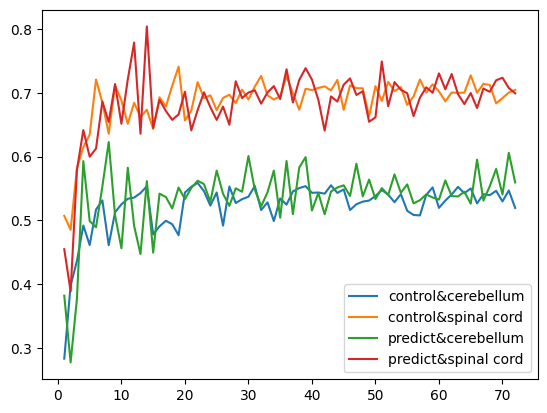

In [9]:
result = {'control&cerebellum': [], 'control&spinal cord': [], 'predict&cerebellum': [], 'predict&spinal cord': []}
for num in range(1, len(target_hic)):
    result['control&cerebellum'].append(
        cal_pearson(target_hic, _schic_range, cerebellum_interactions, _bulk_range, num))
    result['control&spinal cord'].append(
        cal_pearson(target_hic, _schic_range, spinal_cord_interactions, _bulk_range, num))
    result['predict&cerebellum'].append(
        cal_pearson(pred_hic, _schic_range, cerebellum_interactions, _bulk_range, num))
    result['predict&spinal cord'].append(
        cal_pearson(pred_hic, _schic_range, spinal_cord_interactions, _bulk_range, num))

x = list(range(1, len(target_hic)))
for key in result.keys():
    plt.plot(x, result[key], label=key)
plt.legend()
plt.show()